In [2]:
# GENERAL imports
from __future__ import division
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.constants import e
from functools import partial
import sys
BIN=os.path.expanduser('~')
sys.path.append(BIN)
import line_profiler
%load_ext line_profiler
import time
from pprint import pprint

%matplotlib inline
# set the CUDA_DEVICE variable:
os.environ["CUDA_DEVICE"] = "1"

# GPU specific imports / definitions

from pycuda.autoinit import context
from pycuda import gpuarray
from pycuda import driver as cuda
from pycuda import cumath

import PyPIC.meshing as meshing
from PyPIC.poisson_solver import FD_solver, FFT_solver
from PyPIC.pypic import PyPIC_GPU, PyPIC_Fortran_M2P_P2M
sys.path.append('../')

from PyPIC.old import FFT_OpenBoundary_SquareGrid as FFT_old

import PyHEADTAIL
from PyHEADTAIL import gpu
from PyCERNmachines.CERNmachines import SPS

#from backwards_compatibility_1_02 import *
#import FFFT_OpenBoundary_SquareGrid as PIC_old_FFT


PyHEADTAIL v1.4.1-23-gf8be831a76




In [3]:
class Timer(object):
    def __init__(self, verbose=False):
        self.verbose = verbose

    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.secs = self.end - self.start
        self.msecs = self.secs * 1000  # millisecs
        if self.verbose:
            print 'elapsed time: %f ms' % self.msecs

In [4]:
def measurement_GPU(nx, ny, n_particles):
    # mesh and particles parameters
    # leave isotropic as the analytical solutions for E_x, E_y assume round beam
    intensity = 0.5 * 2.5e11
    epsn_x = 2.5e-6
    epsn_y = 2.5e-6
    sigma_z = 0.23
    
    np.random.seed(0)
    machine = SPS(n_segments=1, machine_configuration='Q20-injection')
    beam = machine.generate_6D_Gaussian_bunch_matched(
        n_macroparticles=n_particles, intensity=intensity, 
        epsn_x=epsn_x, epsn_y=epsn_y, sigma_z=sigma_z)
    print type(beam.x)
    offset_part = 0.01
    x0 = gpuarray.min(beam.x).get()
    y0 = gpuarray.min(beam.y).get()
    offset_x = offset_part * np.abs(x0)
    offset_y = offset_part * np.abs(y0)
    x0 -= offset_x
    y0 -= offset_y
    dx = (gpuarray.max(beam.x).get() - x0 + 2*offset_x) / (nx - 3)
    dy = (gpuarray.max(beam.y).get() - y0 + 2*offset_y) / (ny - 3)

    # 1 node empty around the mesh for boundary conditions
    x0 -= dx
    y0 -= dy
    
    # make dx, dy equal, needed for old cpu implementation
    dx = np.max(dx,dy)
    dy = np.max(dx,dy)

    mesh = meshing.RectMesh2D(x0, y0, dx, dy, nx, ny, mathlib=cumath)
    
    timings = dict()
    info = {'device': 'GPU', 'nx': nx, 'ny': ny, 'n_particles': n_particles}
        
    
    with Timer() as t:
        pypic = PyPIC_GPU(mesh, FFT_solver.GPUFFTPoissonSolver(mesh, context), context)
    timings['time_init'] = t.secs

    mod = gpu.thrust_interface.compiled_module
    get_sort_perm_int = mod.get_sort_perm_int
    lower_bound_int = mod.lower_bound_int
    upper_bound_int = mod.upper_bound_int
    
    idx = gpuarray.zeros(n_particles, dtype=np.int32)
    
    
    # time m2p including the sorting of the particles
    with Timer() as t:
        get_sort_perm_int(mesh.get_node_ids(beam.x, beam.y), idx)
        beam.reorder(idx)
        node_ids = mesh.get_node_ids(beam.x, beam.y)
        lower_bounds = gpuarray.empty(mesh.n_nodes, dtype=np.int32)
        upper_bounds = gpuarray.empty(mesh.n_nodes, dtype=np.int32)
        seq = gpuarray.arange(mesh.n_nodes, dtype=np.int32)
        lower_bound_int(node_ids, seq, lower_bounds)
        upper_bound_int(node_ids, seq, upper_bounds)
        mesh_charges = pypic.sorted_particles_to_mesh(
            beam.x, beam.y, 
            lower_bounds=lower_bounds, upper_bounds=upper_bounds
        )
        context.synchronize()
    timings['time_p2m'] = t.secs
    
    rho = mesh_charges/mesh.volume_elem
    

    with Timer() as t:
        phi = pypic.poisson_solve(rho) 
    timings['time_poisson_solve'] = t.secs
    
    with Timer() as t:
        mesh_e_fields = pypic.get_electric_fields(phi) 
    timings['time_gradient'] = t.secs
    
    mesh_fields_and_mp_coords = zip(list(mesh_e_fields), [beam.x, beam.y])

    with Timer() as t:
        particles_e_fields = pypic.field_to_particles(*mesh_fields_and_mp_coords)
    timings['time_m2p'] = t.secs
    
     #     # measurement of the whole solve
    with Timer() as t:
        pypic.pic_solve(beam.x, beam.y, lower_bounds=lower_bounds, upper_bounds=upper_bounds)
    timings['time_solve'] = t.secs
    
    result = dict()
    result['timings'] = timings
    result['phi'] = phi.get()
    result['info'] = info
    return result
    
    
    

In [5]:
def measurement_CPU(nx, ny, n_particles):
    
    
    # mesh and particles parameters
    # leave isotropic as the analytical solutions for E_x, E_y assume round beam
    intensity = 0.5 * 2.5e11
    epsn_x = 2.5e-6
    epsn_y = 2.5e-6
    sigma_z = 0.23
    
    np.random.seed(0)
    machine = SPS(n_segments=1, machine_configuration='Q20-injection')
    beam = machine.generate_6D_Gaussian_bunch_matched(
        n_macroparticles=n_particles, intensity=intensity, 
        epsn_x=epsn_x, epsn_y=epsn_y, sigma_z=sigma_z)
    
    
    offset_part = 0.01
    x0 = min(beam.x)
    y0 = min(beam.y)
    offset_x = offset_part * np.abs(x0)
    offset_y = offset_part * np.abs(y0)
    x0 -= offset_x
    y0 -= offset_y
    dx = (max(beam.x) - x0 + 2*offset_x) / (nx - 3)
    dy = (max(beam.y) - y0 + 2*offset_y) / (ny - 3)

    # 1 node empty around the mesh for boundary conditions
    x0 -= dx
    y0 -= dy
    
    print dx, dy, x0, y0
    # make dx, dy equal
    dx = np.max(dx,dy)
    dy = np.max(dx,dy)
    x = beam.x
    y = beam.y

    mesh = meshing.RectMesh2D(x0, y0, dx, dy, nx, ny, mathlib=np)
    
    class fake_chamb(object):
        def __init__(self, mesh):
            self.mesh = mesh
            self.x_aper = self.mesh.dx*(self.mesh.nx-1) / 2. 
            self.y_aper = self.mesh.dy*(self.mesh.ny-1) / 2. 
            self.is_outside = np.vectorize(self.is_outside_scalar)
        def is_outside_scalar(self, x, y):
            in_x = self.mesh.x0 < x < self.mesh.x0 + self.mesh.dx*(self.mesh.nx-1)
            in_y = self.mesh.y0 < y < self.mesh.y0 + self.mesh.dy*(self.mesh.ny-1)
            return not(in_x and in_y)
    
    chamber = fake_chamb(mesh)
    print mesh.x0, mesh.y0, mesh.dx*mesh.nx + mesh.x0, mesh.dy*mesh.ny + mesh.y0
    
    assert mesh.dx == mesh.dy
    
    timings = dict()
    info = {'device': 'CPU (Gianni)', 'nx': nx, 'ny': ny, 'n_particles': n_particles}
    xg = np.arange(mesh.x0, mesh.x0+mesh.nx*mesh.dx, dx)
    yg = np.arange(mesh.y0, mesh.y0+mesh.ny*mesh.dy, dy)

    with Timer() as t:
        pypic = FFT_old.FFT_OpenBoundary_SquareGrid(x_aper=None, y_aper=None, Dh=None,
                                                    xg=xg, yg=yg, fftlib='pyfftw')

    timings['time_init'] = t.secs
    print pypic.Nxg, pypic.Nyg
    
    
    
    
    
    #convenience wrapper for the whole solve routine
    def solve(pypic, x, y):
        pypic.scatter(x,y, np.ones(len(x)),charge=e)
        pypic.solve()
        pypic.gather(x,y)
    
    # measurement of the whole solve
    with Timer() as t:
        solve(pypic, x, y)
    timings['time_solve'] = t.secs
   
    
#     # fine grained timing of solve
    with Timer() as t:
        pypic.scatter(x, y, np.ones(len(x)),charge=e)
    timings['time_p2m'] = t.secs
    
    with Timer() as t:
        pypic.solve()
    timings['time_poisson_solve'] = t.secs

    with Timer() as t:
        pypic.gather(x,y)
    timings['time_m2p'] = t.secs
    
    result = dict()
    result['timings'] = timings
    result['phi'] = pypic.phi.T
    result['info'] = info
    
    return result
    
    
    

Synchrotron init. From kwargs: machine_configuration = 'Q20-injection'
Synchrotron init. From kwargs: n_segments = 1
*** Maximum RMS bunch length 0.235788291837m.
... distance to target bunch length: -2.4290e-02
... distance to target bunch length: -2.4255e-02
... distance to target bunch length: -9.4232e-03
... distance to target bunch length: -5.0846e-03
... distance to target bunch length: -2.0166e-03
... distance to target bunch length: -6.6153e-04
... distance to target bunch length: -1.2571e-04
... distance to target bunch length: -9.7555e-06
... distance to target bunch length: -1.5712e-07
... distance to target bunch length: -1.9993e-10
--> Bunch length: 0.23
--> Emittance: 0.407764779947
<class 'pycuda.gpuarray.GPUArray'>
{'info': {'device': 'GPU', 'n_particles': 1048576, 'nx': 1024, 'ny': 1024},
 'phi': array([[ 0.01249796,  0.01250083,  0.01250369, ...,  0.01257446,
         0.0125716 ,  0.01256873],
       [ 0.01250084,  0.01250371,  0.01250659, ...,  0.01257749,
         0

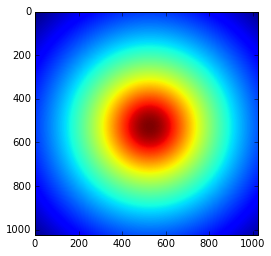

In [6]:
nnxx = 1024
test = measurement_GPU(nnxx, nnxx, 1024*1024)

pprint(test)
plt.imshow(test['phi'].reshape(nnxx, nnxx))
plt.show()
# test = measurement_CPU(nnxx, nnxx, 1024*1024)
# pprint(test)
# plt.imshow(test['phi'])
# print test['phi'].shape
plt.show()



def plot_potential_slice(phiGPU, phiCPU, slicenr):
    plt.plot(phiGPU.get().reshape(256,256)[slicenr,:], label='GPU')
    plt.plot(phiCPU.reshape(256,256)[slicenr,:], label='PyPIC (Gianni)')
    plt.legend()
    plt.title('comparison: potential on mesh')
    plt.xlabel('mesh cell')
    plt.ylabel('potential')
    plt.savefig('pot_slice.png')

In [7]:
def write_pickle(meshsizes, particle_numbers, measurement_fn, **kwargs):
    ''' meshsizes: iterable list with the nx=ny mesh dimensions
    particle_nubmers: iterable list with the number of particles
    measurement_fn: function to call
    **kwargs: additional arguments for measurement_fn (additional to nx, ny, np) e.g. permspec_c
    fileid: additional info written to the filename, e.g. 'sym=False_cspec=COLAMD'
    '''
    infolist = [str(kk) + '=' + str(val) for kk, val in kwargs.iteritems()]
    infostr = '-'.join(infolist)
    for nx in meshsizes:
        for np in particle_numbers:
            print('-------------' + str(nx) + ' ' + str(np) + '---------------------')
            fname = '../data/' + 'nx=' + str(nx) + '-np=' + str(np) + '-'+ infostr +'.pickle'
            #fname = 'data2/' + 'nx=' + str(nx) + '-np=' + str(np) + '-CHOL.pickle'
            print fname
            timing = measurement_fn(nx, nx, np)
            pprint(timing['timings'])
            
            with open(fname, 'wb') as handle:
                pickle.dump(timing, handle)    








In [8]:
nx_ = [128, 256,512, 1024]
#nx_ = [1024]
np_ = [500*1024, 1000*1024, 2*1000*1024, 5*1000*1024,10*1000*1024]
#np_ = [5*1000*1024,10*1000*1024]

#np_ = [2*1000*1024, 5*1000*1024]

write_pickle(meshsizes=nx_, particle_numbers=np_, measurement_fn=measurement_GPU, mode='GPU')
#write_pickle(meshsizes=nx_, particle_numbers=np_, measurement_fn=measurement_CPU, mode='CPU')

-------------1024 5120000---------------------
../data/nx=1024-np=5120000-mode=GPU.pickle
Synchrotron init. From kwargs: machine_configuration = 'Q20-injection'
Synchrotron init. From kwargs: n_segments = 1
*** Maximum RMS bunch length 0.235788291837m.
... distance to target bunch length: -2.4290e-02
... distance to target bunch length: -2.4255e-02
... distance to target bunch length: -9.4232e-03
... distance to target bunch length: -5.0846e-03
... distance to target bunch length: -2.0166e-03
... distance to target bunch length: -6.6153e-04
... distance to target bunch length: -1.2571e-04
... distance to target bunch length: -9.7555e-06
... distance to target bunch length: -1.5712e-07
... distance to target bunch length: -1.9993e-10
--> Bunch length: 0.23
--> Emittance: 0.407764779947
<class 'pycuda.gpuarray.GPUArray'>
{'time_gradient': 0.0012049674987792969,
 'time_init': 0.40253400802612305,
 'time_m2p': 0.042047977447509766,
 'time_p2m': 0.10587906837463379,
 'time_poisson_solve': 0